# Introduction

The popularity of Airbnb as an alternative to traditional hotels and accommodations has surged. With its diverse range of property types and flexible pricing options, Airbnb has become the go-to platform for many travelers visiting new cities, including Seattle. 

As a result, it is essential for hosts to understand the dynamics of pricing within the market to remain competitive and maximize their earnings. In this project, we aim to analyze and provide insights into the pricing trends of Airbnb listings in Seattle, as well as develop a predictive model for estimating the price of new listings.

By using up-to-date data from Inside Airbnb as of 12-24-2022, we will explore various aspects of the listings, such as the impact of location, property type, and amenities on pricing. We will also identify key trends and patterns to help hosts make informed decisions regarding their pricing strategies. Furthermore, we will implement machine learning algorithms to predict the price of listings based on their features. This predictive model will serve as a valuable tool for hosts to gauge the appropriate price for their listings, ultimately enhancing their profitability and success in the competitive Seattle Airbnb market.

As you can see the Seattle's Airbnb market, uncovering valuable insights and creating a powerful pricing prediction tool that can empower hosts to optimize and suggest their listings for maximum returns.

In [1]:
# load required packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# the dataset from inside airbnb website
url = "http://data.insideairbnb.com/united-states/wa/seattle/2022-12-24/data/listings.csv.gz"
# load dataset
df_listing = pd.read_csv(url, low_memory=False)
print("Total row and column in the dataset :",df_listing.shape)


Total row and column in the dataset : (6166, 75)


# Preprocessing and data cleaning

•Importing data and installing required packages.

•Find missing data and drop unnecessary columns for analysis.

•Data imputation process

In [2]:
# Calculate the percentage of missing values in each column
percent_missing = df_listing.isnull().sum() * 100 / len(df_listing)

# Select columns with missing values greater than or equal to 10%
missing_above_10pct = percent_missing[percent_missing >= 10]

# Print the percentage of missing values in selected columns
print("Percentage of missing values by column:")
print(round(missing_above_10pct,1))

Percentage of missing values by column:
neighborhood_overview           26.9
host_location                   13.8
host_about                      27.9
host_response_time              12.2
host_response_rate              12.2
neighbourhood                   26.9
bathrooms                      100.0
bedrooms                        11.6
calendar_updated               100.0
first_review                    17.3
last_review                     17.3
review_scores_rating            17.3
review_scores_accuracy          17.3
review_scores_cleanliness       17.3
review_scores_checkin           17.3
review_scores_communication     17.3
review_scores_location          17.3
review_scores_value             17.3
license                         22.9
reviews_per_month               17.3
dtype: float64


In [3]:
#Remove unnecessary columns and rows that are missing values 
columns_to_drop = ['source', 'description', 'listing_url', 'host_thumbnail_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'last_scraped', 'scrape_id', 'calendar_updated', 'host_has_profile_pic', 'host_since', 'host_identity_verified', 'host_acceptance_rate', 'bathrooms_text', 'first_review', 'host_about', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'neighbourhood_cleansed', 'host_response_time', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'calendar_last_scraped', 'number_of_reviews_l30d', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']

# Find the intersection of columns_to_drop and the columns in df_listing
columns_to_drop = set(columns_to_drop).intersection(df_listing.columns)

# Drop the columns
df_listing.drop(columns=columns_to_drop, axis=1, inplace=True)


In [4]:
## Imputation is a process of replacing missing values in a dataset

df_listing.fillna({'bathrooms':1, 'bedrooms':1, 'beds':1}, inplace=True)

df_listing.fillna({'last_review':0, 'review_scores_rating':0, 'review_scores_accuracy':0, 'review_scores_cleanliness':0, 
        'review_scores_checkin':0, 'review_scores_communication':0, 'review_scores_location':0,
        'review_scores_value':0,'reviews_per_month':0,'neighborhood_overview':'NA','description':'NA',
        'host_is_superhost':'f','name':'NA','host_response_rate':'N/A',
        'host_neighbourhood':'NA','host_listings_count':0,
                  }, inplace=True)

In [5]:
# Check missing values in the dataframe

missing_cols = df_listing.columns[df_listing.isna().sum() > 0]
if missing_cols.empty:
    print("No missing values.")
else:
    missing_data = df_listing.loc[:,missing_cols]
    print("Missing values\n",missing_data.isna().sum())

Missing values
 host_location     848
neighbourhood    1656
license          1414
dtype: int64


In [6]:
#check datatypes for cleaned data
df_listing.dtypes

id                                  int64
name                               object
neighborhood_overview              object
host_id                             int64
host_name                          object
host_location                      object
host_response_rate                 object
host_is_superhost                  object
host_neighbourhood                 object
neighbourhood                      object
neighbourhood_group_cleansed       object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                      int64
maximum_nights                      int64
has_availability                  

In [7]:
#converting features from "t" and "f" to 1's and 0's

df_listing['host_is_superhost'] = df_listing['host_is_superhost'].apply(lambda x: 1 if x == "t" else 0)
df_listing['instant_bookable'] = df_listing['instant_bookable'].apply(lambda x: 1 if x == "t" else 0)
df_listing['has_availability'] = df_listing['has_availability'].apply(lambda x: 1 if x == "t" else 0)

In [8]:
# After treating data preprocessing, imputation
print("Total row and column in the dataset :",df_listing.shape)

Total row and column in the dataset : (6166, 42)


# Data Exploratory and Analysis (in visualization)

•What is the average price, per night, of an Airbnb listing in Seattle, Washinton? •How does the average price of an Airbnb listing, per month, compare to the private rental market?

•How many adverts are for private rooms?

•How do Airbnb listing prices compare across the top 10 Seattle apartments/homes?

•What are the most popular neighborhoods for Airbnb rentals in Seattle, Washinton, and how do prices vary between these neighborhoods?

•What types of properties are most commonly listed on Airbnb in Seattle, Washinton (e.g., apartments, houses, etc.)?

•What are the most common amenities and features offered in Airbnb rentals in Seattle, Washinton, and how do they impact the price?

•How have Airbnb prices in Seattle, Washinton changed over time, and what factors have contributed to these changes?

In [9]:
# Remove $ sign and comma from the price column
df_listing["price"] = df_listing['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
# Convert the price column to a numeric type
df_listing["price"] = pd.to_numeric(df_listing['price'])
print(df_listing["price"])


0       133.0
1        99.0
2       130.0
3        60.0
4        56.0
        ...  
6161    234.0
6162    133.0
6163    151.0
6164    188.0
6165    114.0
Name: price, Length: 6166, dtype: float64


**Find the the correlation coefficients of price with the other variables**


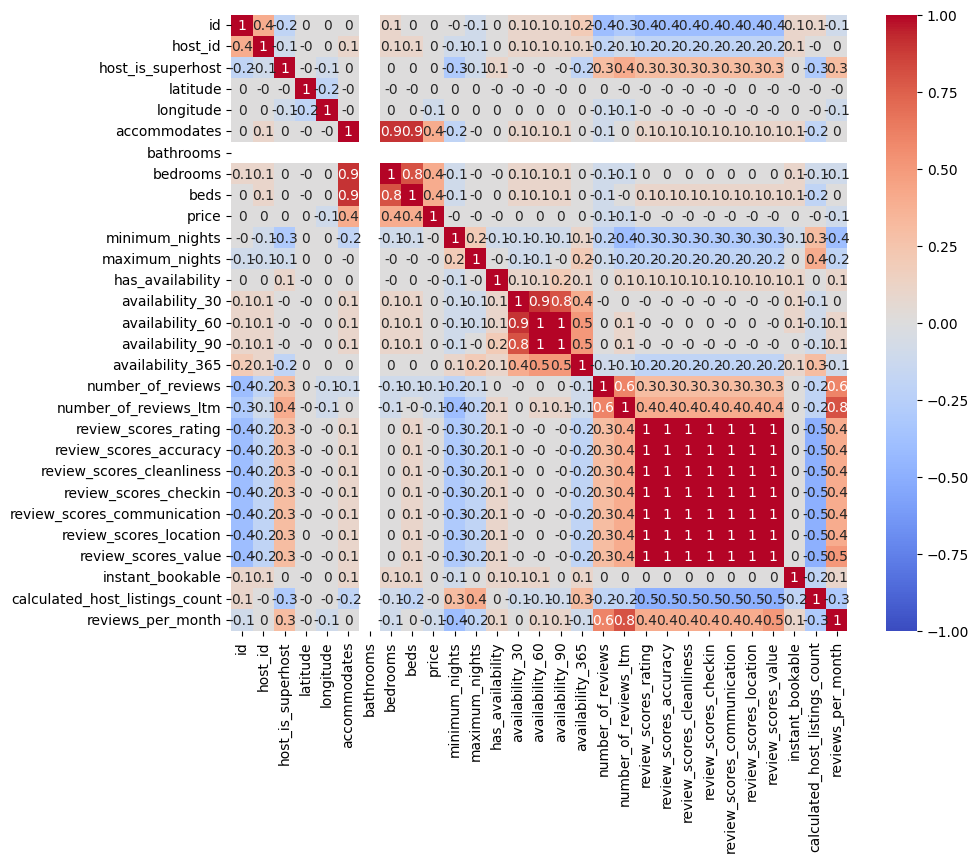

In [10]:
# create correlation matrix
corr_matrix = df_listing.corr().round(1)
# plot the matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)
plt.show()

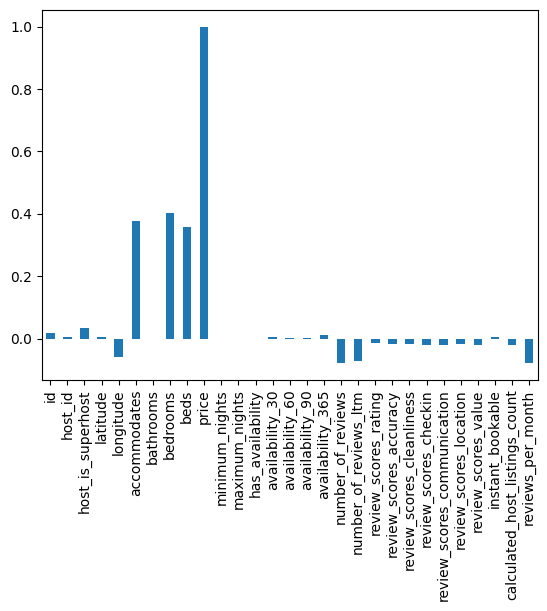

In [11]:
corr_matrix = df_listing.corr()
price_correlations = corr_matrix.loc['price']
price_correlations.plot.bar()
plt.show()


**Relationship between price and other varaibles**


accommodates        0.376287
bedrooms            0.401453
beds                0.358719
price               1.000000
instant_bookable    0.004477
Name: price, dtype: float64


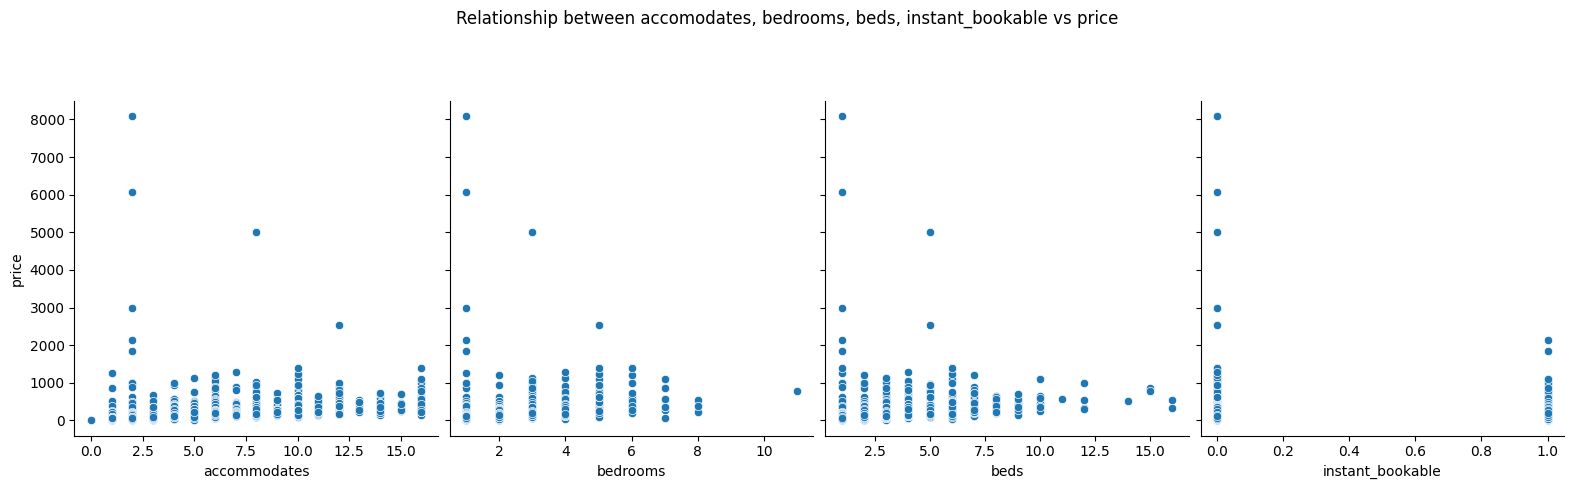

In [12]:
# Select the numeric columns of interest that have a stronger associated with price
num_st_cols = ['accommodates', 'bedrooms', 'beds','price', 'instant_bookable']
df = df_listing[num_st_cols]

# Create the scatter pairplot
g = sns.pairplot(df, x_vars=['accommodates', 'bedrooms', 'beds', 'instant_bookable'], y_vars=['price'], height=4 )
g.fig.suptitle('Relationship between accomodates, bedrooms, beds, instant_bookable vs price', y=1.2)

corr_price = df_listing[num_st_cols].corr()
print(corr_price['price'])

availability_30     0.006130
availability_60     0.001439
price               1.000000
availability_90     0.000906
availability_365    0.012443
Name: price, dtype: float64


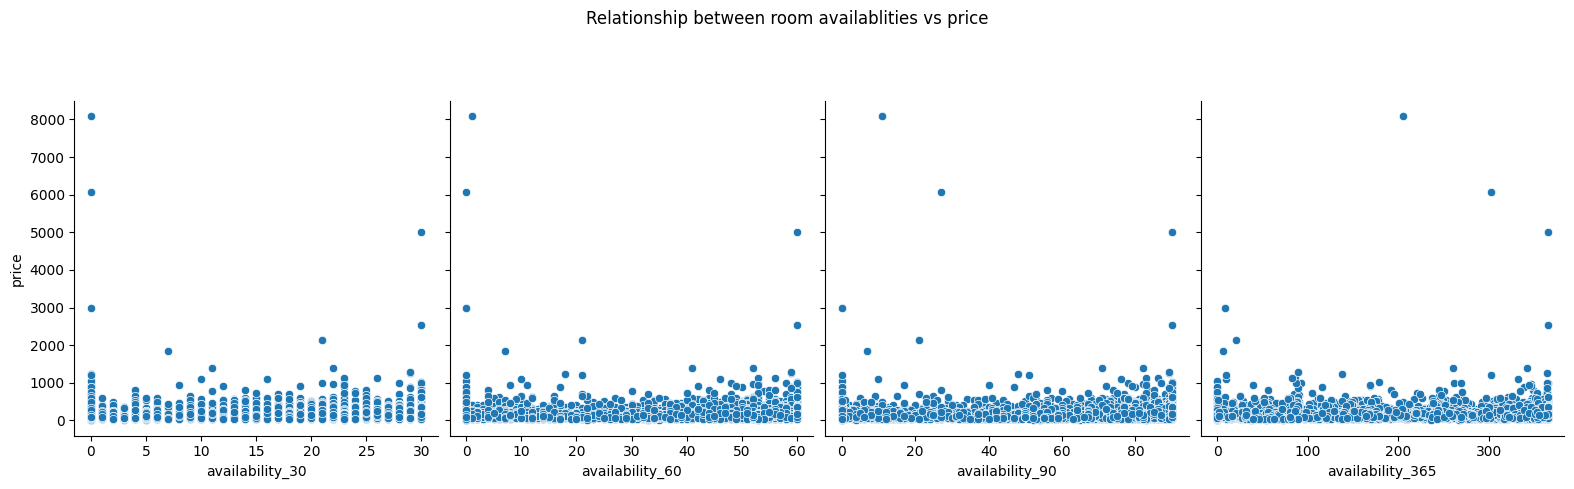

In [13]:
# Select the numeric columns of interest that have a weaker associated with price
num_we_cols = ['availability_30', 'availability_60','price', 'availability_90', 
               'availability_365']
df = df_listing[num_we_cols]

# Create the scatter pairplot
g = sns.pairplot(df, x_vars=[ 'availability_30', 'availability_60', 'availability_90', 
               'availability_365'], y_vars=['price'], height=4 )
g.fig.suptitle('Relationship between room availablities vs price', y=1.2)

corr_price = df_listing[num_we_cols].corr()
print(corr_price['price'])


In [14]:
#Find average price per night of AirBnb in NY
avg_price_per_night = df_listing["price"].mean()

#Find average price per month of Airbnb in Seattle
avg_monthly_price = round(avg_price_per_night*365/12, 2)

#Conclude the comparision between monthly price of AirBnb and that of private market in NY
print("Average monthly AirBnb price in Seattle: ", round(avg_monthly_price))

Average monthly AirBnb price in Seattle:  5095


In [15]:
#Lowercase room column
df_listing['room_type'].map(lambda x: x.lower())

#Count the frequency of room types
num_room_types = df_listing['room_type'].value_counts()
num_room_types

Entire home/apt    5225
Private room        927
Shared room          12
Hotel room            2
Name: room_type, dtype: int64

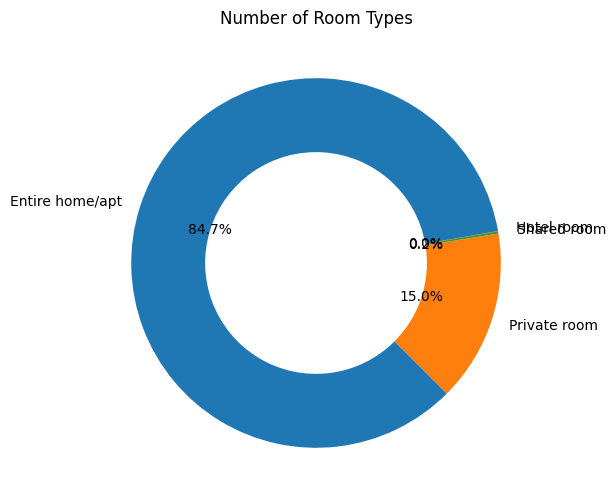

In [16]:
# Plot the pie chart
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(num_room_types, labels=num_room_types.index, startangle=10, autopct='%1.1f%%', wedgeprops={'width':0.4})
ax.set_aspect('equal')
ax.set_title('Number of Room Types')
plt.show()

In [17]:
#Average price of each room types
total_price_of_each_room_type = df_listing.groupby(['room_type']).sum()['price']

price_of_each_room_type = total_price_of_each_room_type/num_room_types

price_of_each_room_type

Entire home/apt    180.783541
Hotel room           0.000000
Private room        94.495146
Shared room         61.000000
dtype: float64

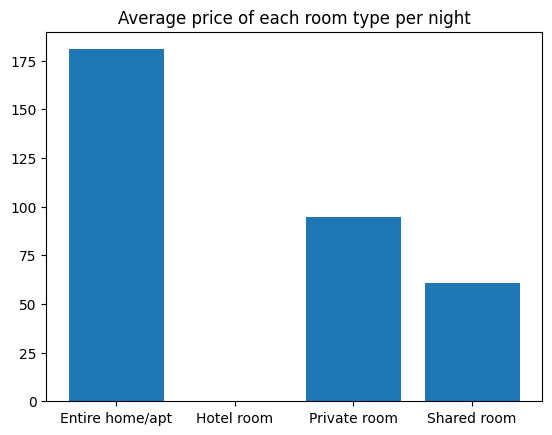

In [18]:
#barplot shows comparision between number of room and average price per night of each type
room_types = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']
plt.bar(room_types, price_of_each_room_type)
plt.title("Average price of each room type per night")
plt.show()

In [19]:
neighbourhood_group = df_listing.groupby('neighbourhood_group_cleansed').agg({'price':['max','min', 'mean', 'median', 'count']})
print(round(neighbourhood_group))

                               price                          
                                 max   min   mean median count
neighbourhood_group_cleansed                                  
Ballard                        895.0  29.0  173.0  140.0   369
Beacon Hill                    549.0  13.0  143.0  119.0   279
Capitol Hill                  1200.0  25.0  170.0  132.0   539
Cascade                        900.0   0.0  164.0  140.0   300
Central Area                  6080.0  20.0  185.0  134.0   514
Delridge                      8088.0  28.0  173.0  101.0   192
Downtown                      3000.0   0.0  167.0  145.0   808
Interbay                      1400.0  59.0  145.0   68.0    41
Lake City                      918.0  24.0  158.0  112.0   110
Magnolia                       956.0  39.0  193.0  152.0    90
Northgate                      750.0  23.0  117.0   90.0   218
Other neighborhoods           5000.0  24.0  169.0  128.0  1234
Queen Anne                    2529.0  20.0  219.0  158.

Map of Neighbourhood Group

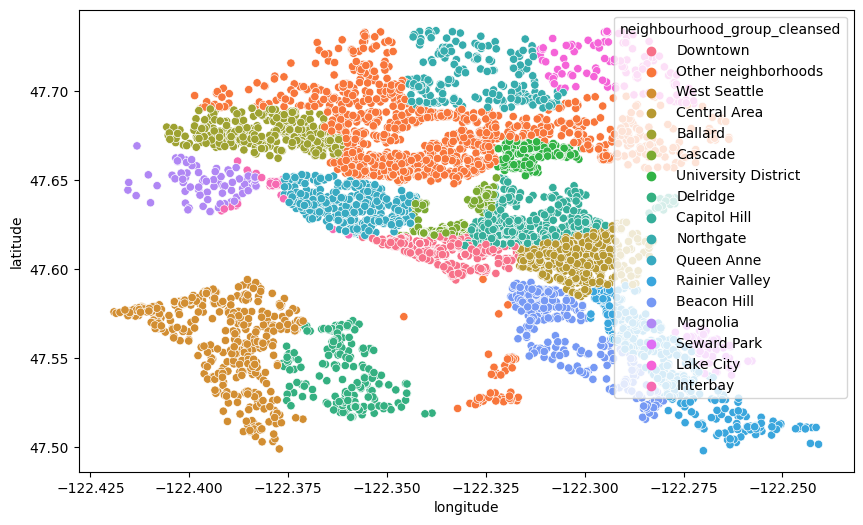

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_listing.longitude, y=df_listing.latitude, hue=df_listing.neighbourhood_group_cleansed)
plt.ioff()

Availability of Room

In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_listing.longitude,y=df_listing.latitude,hue=df_listing.availability_365)
plt.ioff()

**Find the most popular neighborhoods for AirBnb rentals in Seattle and show how price vary between these neighborhoods**

Now, we assume that there are five range of price to categorize the AirBnb in Seattle, Washinton, including:

Budget: $0 - 100

Average: $101 - 200

Expensive: $201 - 400

Luxury: > $401 - 1000

Presidential: > $1000

Now, we analyze number of AirBnb in different boroughs

In [22]:
#Create list of rank for AirBnb room
rank_room = ["Budget", "Average", "Expensive", "Luxury", "Presidential"]

#Create the range
ranges = [0, 100, 200, 400, 1000, np.inf]

#Input new column for price_range
df_listing["ranges"] = pd.cut(df_listing["price"], bins=ranges, labels=rank_room)

#Categorize room in different price ranges in boroughs of NY
room_by_price_range = df_listing.groupby(["ranges", "neighbourhood_group_cleansed"])["price"].count()
print(room_by_price_range)

ranges        neighbourhood_group_cleansed
Budget        Ballard                         111
              Beacon Hill                     114
              Capitol Hill                    160
              Cascade                          90
              Central Area                    168
                                             ... 
Presidential  Queen Anne                        5
              Rainier Valley                    0
              Seward Park                       0
              University District               0
              West Seattle                      1
Name: price, Length: 85, dtype: int64


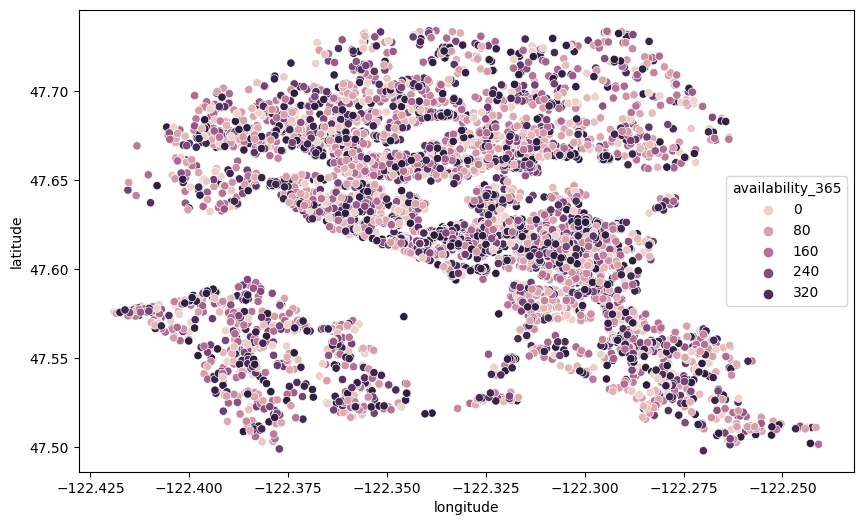

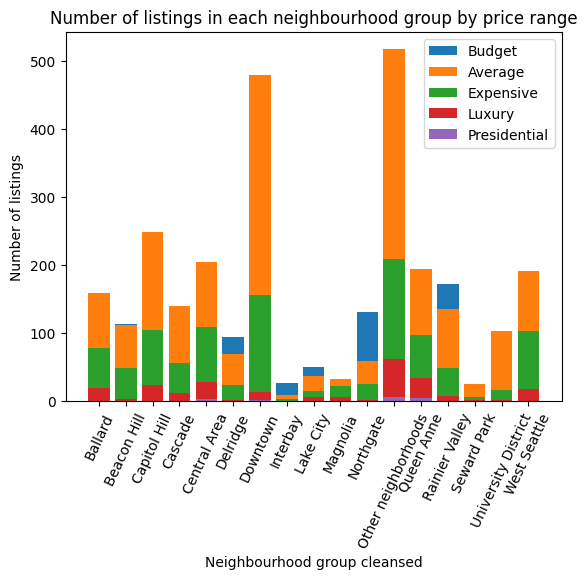

In [23]:
#Create plot for AirBnb room ranks

room_by_price_range = room_by_price_range.reset_index()
price_ranges = room_by_price_range['ranges'].unique()

fig, ax = plt.subplots()
for price_range in price_ranges:
    filtered_df = room_by_price_range[room_by_price_range['ranges'] == price_range]
    ax.bar(filtered_df['neighbourhood_group_cleansed'], filtered_df['price'], label=price_range)

ax.set_xlabel('Neighbourhood group cleansed')
ax.set_ylabel('Number of listings')
ax.legend()
ax.set_title('Number of listings in each neighbourhood group by price range')
# Rotate x-axis labels
plt.xticks(rotation=65)
plt.show()


Most common amenities and features and their impacts on the price

In [24]:
#clean the amenities column
df_listing["amenities"] = df_listing["amenities"].str.replace(r'\\', '', regex=True)

In [25]:
#Count the frequencies of amenities
from collections import Counter
count_amen = Counter()
for row in df_listing['amenities']:
    count_amen.update(row[1:-1].replace("\"", "").split(", "))

In [26]:
#Find top 10 most common amenities
top10_amenities = [a for a, c in list(count_amen.items())[:10]]

In [27]:
#Find the mean price of houses which have one of top 10 most common amenities
amen_vs_mean_price = []
for amen in top10_amenities:
    amen_vs_mean_price.append((
        amen, 
        #df_listing.query("amenities.str.contains(@amen)")["price"].mean(skipna=True)
        df_listing[df_listing['amenities'].str.contains(amen)]['price'].mean()
    ))

sorted_amen_vs_mean_price = sorted(amen_vs_mean_price, key=lambda x: x[1], reverse=True)
sorted_amen_vs_mean_price

[('Pool', 222.1878453038674),
 ('Full kitchen', 193.15384615384616),
 ('Dishwasher', 189.24851270957274),
 ('Bathtub', 182.31944889458507),
 ('TV', 176.9381959910913),
 ('Washer', 175.17690104995228),
 ('Backyard', 170.13039568345323),
 ('Coffee maker', 168.90771323100836),
 ('Gym', 166.83994528043775),
 ('Elevator', 158.0044964028777)]

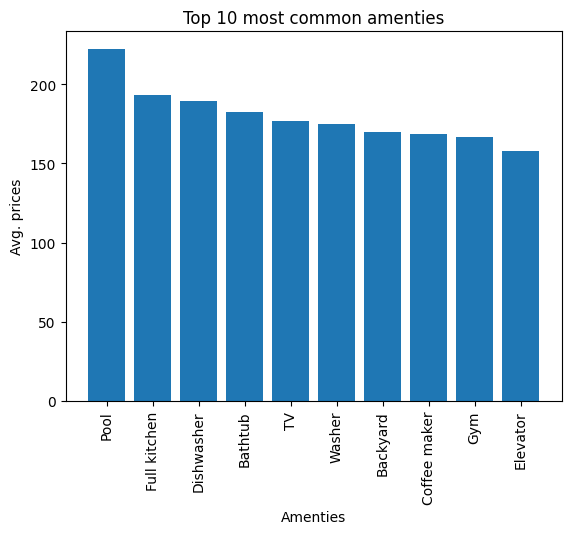

In [28]:
# plot for average price of houses which have one of top 10 most common amenities
labels, values = zip(*sorted_amen_vs_mean_price)

plt.bar(labels, values)
plt.xlabel('Amenties')
plt.ylabel('Avg. prices')
plt.title('Top 10 most common amenties')
plt.xticks(rotation=90)

plt.show()

# Model Fitting & Evaluation

•Prepare machine learning data models such as 
.Normalize numeric features

.Convert the categorical variables into numeric features

.Split the data into a training set and a test set.

.Create models such as (Linear Regression, Random Forest and Gradient Boosting )

.Evaluate the models’ performance and benchmark model accuracy.

In [29]:
#create list for numerical and categorical variable
numerical_vars = ['id', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 
                  'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
                  'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location','price', 'review_scores_value', 'reviews_per_month',
                  'has_availability','instant_bookable','host_is_superhost']

categorical_vars = ['name', 'host_neighbourhood','neighbourhood_group_cleansed', 'host_location', 'host_response_rate', 
                    'host_neighbourhood', 'property_type', 'room_type']

In [30]:
# drop zero variable numerical variables
zero_variance_numerical_variables = [col for col in df_listing.columns if (df_listing[col].dtype in ['int64', 'float64'] and df_listing[col].std() == 0)]

df_listing = df_listing.drop(zero_variance_numerical_variables, axis=1)


In [31]:
# drop zero variable categorical variables
zero_variance_categorical_variables = []

categorical_vars = list(df_listing.dtypes[df_listing.dtypes == object].index)

for i in categorical_vars: 
    if len(df_listing[i].value_counts().index) ==1 :
           zero_variance_categorical_variables.append(i)
                   
df_listing = df_listing.drop(zero_variance_categorical_variables, axis=1)

In [32]:
# drop high cardinality variables with high variance > 200 categorical variables 
high_cardinality_categorical_variables = [] 

categorical_vars = list(df_listing.dtypes[df_listing.dtypes == object].index)

for i in categorical_vars: 
    if len(df_listing[i].value_counts().index) >200 :
           high_cardinality_categorical_variables.append(i)

df_listing = df_listing.drop(high_cardinality_categorical_variables, axis=1)

In [33]:
# standardize and scaling standardize numerical variables
df_listing = df_listing.drop(df_listing.std()[df_listing.std() ==0].index, axis=1)

# extract numerical val
numeric_var = list(set(df_listing.columns) - set(df_listing.dtypes[df_listing.dtypes == object].index))

# create col name for standardize val
new_col = [i for i in numeric_var]

df_listing[numeric_var] = df_listing[numeric_var].apply(pd.to_numeric, errors='coerce')

# convert nurmic_var to numpy array
array = df_listing[numeric_var].values


data_scaler = StandardScaler().fit(array)

df_listing[new_col] = pd.DataFrame(data_scaler.transform(array))

In [34]:
#Remove id columns before encoding
df_listing.drop(columns = ['id'], axis=1, inplace=True)

In [35]:
# encode categorical input variables
categorical_var = list( set(df_listing.dtypes[df_listing.dtypes ==object].index) - set(['price']) )

pd.get_dummies(df_listing[categorical_var], drop_first=True )

dummy_cat_df =pd.get_dummies(df_listing[categorical_var], drop_first=True )

df_listing = df_listing.drop(categorical_var, axis =1)

df_listing = pd.concat([df_listing, dummy_cat_df], axis=1)

df_listing.head()

,host_id,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,ranges,room_type_Hotel room,room_type_Private room,room_type_Shared room,"host_location_Amsterdam, Netherlands","host_location_Anchorage, AK","host_location_Ann Arbor, MI","host_location_Antelope, CA","host_location_Arizona, United States","host_location_Arlington, VA","host_location_Armonk, NY","host_location_Auburn, WA","host_location_Austin, TX",...,property_type_Private room in condo,property_type_Private room in cottage,property_type_Private room in earthen home,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in loft,property_type_Private room in rental unit,property_type_Private room in resort,property_type_Private room in serviced apartment,property_type_Private room in tiny home,property_type_Private room in townhouse,property_type_Private room in treehouse,property_type_Private room in villa,property_type_Room in aparthotel,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Shared room,property_type_Shared room in home,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in townhouse,property_type_Tent,property_type_Tiny home,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,neighbourhood_group_cleansed_Delridge,neighbourhood_group_cleansed_Downtown,neighbourhood_group_cleansed_Interbay,neighbourhood_group_cleansed_Lake City,neighbourhood_group_cleansed_Magnolia,neighbourhood_group_cleansed_Northgate,neighbourhood_group_cleansed_Other neighborhoods,neighbourhood_group_cleansed_Queen Anne,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle
0,-0.856826,1.144652,-0.224912,-0.405146,0.010692,-0.667223,-0.758644,-0.176919,-0.585337,1.206714,0.123071,0.515081,0.391909,0.232875,-0.355568,1.224403,1.109238,0.472779,0.487563,0.501021,0.439681,0.475281,0.509676,0.484902,1.634755,-0.359485,-0.168786,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,-0.886973,-0.873628,0.568858,-0.067345,-1.180774,-0.667223,-0.758644,-0.351177,0.977759,1.206714,0.123071,-1.380871,-0.672714,-0.181023,-0.457141,0.964978,-0.671683,0.353047,0.363254,0.376260,0.428951,0.394827,0.471784,0.369088,-0.611712,-0.359485,-0.455848,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,-0.886973,-0.873628,0.601890,-0.059209,0.010692,-0.667223,1.293923,-0.192294,0.977759,-0.655692,0.123071,0.605365,0.762212,0.805964,-0.918128,0.346347,-0.758557,0.325836,0.298397,0.284045,0.412855,0.341191,0.488023,0.363573,-0.611712,-0.359485,-0.596861,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,-0.856754,1.144652,1.082664,0.767362,-0.783619,-0.667223,-0.758644,-0.551061,0.977759,-0.323479,0.123071,-0.839171,-1.367034,-1.613746,0.292939,0.126833,-0.671683,0.467337,0.482158,0.452201,0.423586,0.459190,0.471784,0.545567,-0.611712,-0.369270,-0.632114,NaN,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,-0.886866,1.144652,-1.531280,0.442520,-0.783619,-0.667223,-0.074455,-0.571562,-0.585337,-0.877168,0.123071,1.327633,1.132516,1.060671,1.277420,1.114646,0.110185,0.402029,0.422706,0

In [36]:
print('No of encoded columns: ',len(df_listing.columns))

No of encoded columns:  485


In [37]:
df_listing['price'] = df_listing['price'].apply(lambda x: 1 if x > 0.5 else 0)
df_listing.price[:5]
df_listing.price

0       0
1       0
2       0
3       0
4       0
       ..
6161    0
6162    0
6163    0
6164    0
6165    0
Name: price, Length: 6166, dtype: int64

In [38]:
# final check before resmaple
df_listing = df_listing.fillna(value=0)
if df_listing.isnull().sum().sum() > 0:
    print("Data contains missing values.")
else:
    print("Data does not contain any missing values.")

Data does not contain any missing values.


In [39]:
# Imbalanced variables to balanced it, using SMOTE resmaple function 
sm = SMOTE(random_state=0)
input_var = list( set(df_listing.columns) - set(['price']) )

X, Y = sm.fit_resample(df_listing[df_listing.columns.difference(['price'])], df_listing['price'] )
X = pd.DataFrame(X, columns = input_var)
y = pd.DataFrame(Y, columns = ['price'])

df_listing = pd.concat([X, Y], axis=1)

In [40]:
#validate balance data
df_listing['price'].value_counts()

0    5391
1    5391
Name: price, dtype: int64

In [41]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('70% Traing dataset: ',X_train.shape[0])
print('30% Test dataset:',X_test.shape[0])

70% Traing dataset:  7547
30% Test dataset: 3235


In [42]:
# Create an XGBoost model

xgb_model = xgb.XGBRegressor()

# Train the model on the training data
xgb_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test).round()

In [43]:
# Create an LinearRegression model

lr_model = LinearRegression()
lr_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred_lr = lr_model.predict(X_test).round()

In [44]:
# Create a random forest model

rf_model = RandomForestRegressor(n_estimators=100)

# Train the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test).round()

# Feature importances indication

In [45]:
# get the feature importances
importance = rf_model.feature_importances_
cols =[]
scores =[]
# extract importances/significant feature score
for i,v in enumerate(importance):
    if v >= 0.01:
        #print('Feature: %0d, Score: %.3f' % (i,v))
        cols.append(i)
        scores.append(v)

In [46]:
# extract importances/significant feature score
feature_name =[]
for i, v in enumerate(input_var):
    #print(i,v)
    if i in cols:
        #print(i, v)
        feature_name.append(v)

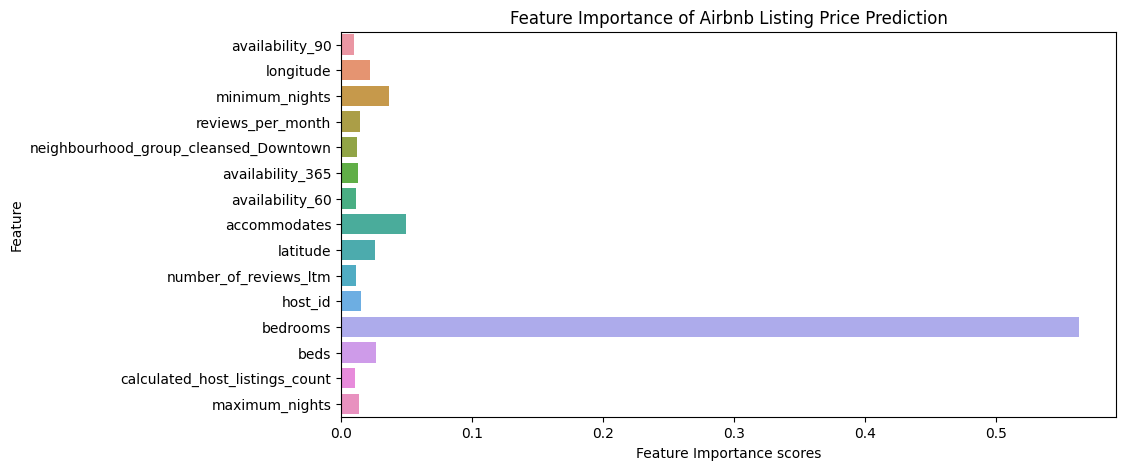

In [47]:
# create a bar plot
plt.figure(figsize=(10,5))
sns.barplot(x=scores, y=feature_name)
plt.xlabel('Feature Importance scores')
plt.ylabel('Feature')
plt.title('Feature Importance of Airbnb Listing Price Prediction')
plt.show()

**Reasons why they are impacting the Airbnb listing price prediction:**

**minimum_nights**: Minimum nights required to book a stay at a listing may impact the price, as longer stays may be priced differently than shorter stays.

**availability_30**: Number of days the listing is available in the next 30 days may impact the price, as listings with more availability may be priced differently than those with less availability.

**number_of_reviews**: Number of reviews a listing has may impact the price, as listings with more reviews may be priced differently than those with fewer reviews.

**accommodates**: Number of guests a listing can accommodate may impact the price, as listings that can accommodate more guests may be priced differently than those that can accommodate fewer guests.

**longitude and latitude**: The location of the listing may impact the price, as listings in certain areas may be priced differently than those in other areas.

**room_type_Private room**: The type of room may impact the price, as different types of rooms may be priced differently.

**bedrooms**: Number of bedrooms may impact the price, as listings with more bedrooms may be priced differently than those with fewer bedrooms.

**maximum_nights**: Maximum nights allowed to book a stay at a listing may impact the price, as longer stays may be priced differently than shorter stays.

# Confusion Matrix for model performance indicator

In [48]:
# compute confusion matrix and model performance indicator
def get_performance(actual_Y, pred_Y):
    cm = confusion_matrix(actual_Y, pred_Y)
    total = sum(sum(cm))
    accuracy = (cm[0,0] + cm[1,1] )/ total
    sensitivity = cm[0,0] / ( cm[0,0] + cm[0,1] )
    specificity = cm[1,1]/( cm[1,0] + cm[1,1] )
    return accuracy, sensitivity, specificity

In [49]:
acc_xgb, sens_xgb, spec_xgb = get_performance(y_test, y_pred_xgb)

threshold = 0.5
y_pred_lr_binary = np.where(y_pred_lr > threshold, 1, 0)

acc_lr, sens_lr, spec_lr = get_performance(y_test,  y_pred_lr_binary)

acc_rf, sens_rf, spec_rf = get_performance(y_test, y_pred_rf)

# Model Evaluation (Accuracy, Sensitivity, Specificity)

In [50]:
# models performance evaluation
perf_tbl = pd.DataFrame([acc_xgb ,acc_lr, acc_rf], columns = ['Accuracy'], 
                               index=['Gradient Boosting','Linear Regression','Random Forest'])

perf_tbl['Sensitivity'] = np.asarray([sens_xgb, sens_lr, sens_rf])
perf_tbl['Specificity'] = np.asarray([spec_xgb, spec_lr, spec_rf])

perf_tbl.head(5)

,Accuracy,Sensitivity,Specificity
Gradient Boosting,0.943431,0.949662,0.937111
Linear Regression,0.921484,0.945979,0.896638
Random Forest,0.944668,0.949048,0.940224


In [51]:
# models performance evaluation metrics ( MAE, MSE and R^2)
perf_tbl1 = pd.DataFrame([mean_absolute_error(y_test, y_pred_xgb), mean_absolute_error(y_test, y_pred_lr) , mean_absolute_error(y_test, y_pred_rf) ], 
                         columns = ['MAE'], 
                               index=['Gradient Boosting','Linear Regression','Random Forest'])

perf_tbl1['MSE'] = np.asarray([mean_squared_error(y_test, y_pred_xgb), mean_squared_error(y_test, y_pred_lr) , mean_squared_error(y_test, y_pred_rf)])
perf_tbl1['R^2'] = np.asarray([r2_score(y_test, y_pred_xgb), r2_score(y_test, y_pred_lr) ,r2_score(y_test, y_pred_rf)])

perf_tbl1.head()

,MAE,MSE,R^2
Gradient Boosting,0.056569,0.056569,0.773713
Linear Regression,0.079444,0.079444,0.682210
Random Forest,0.055332,0.055332,0.778660


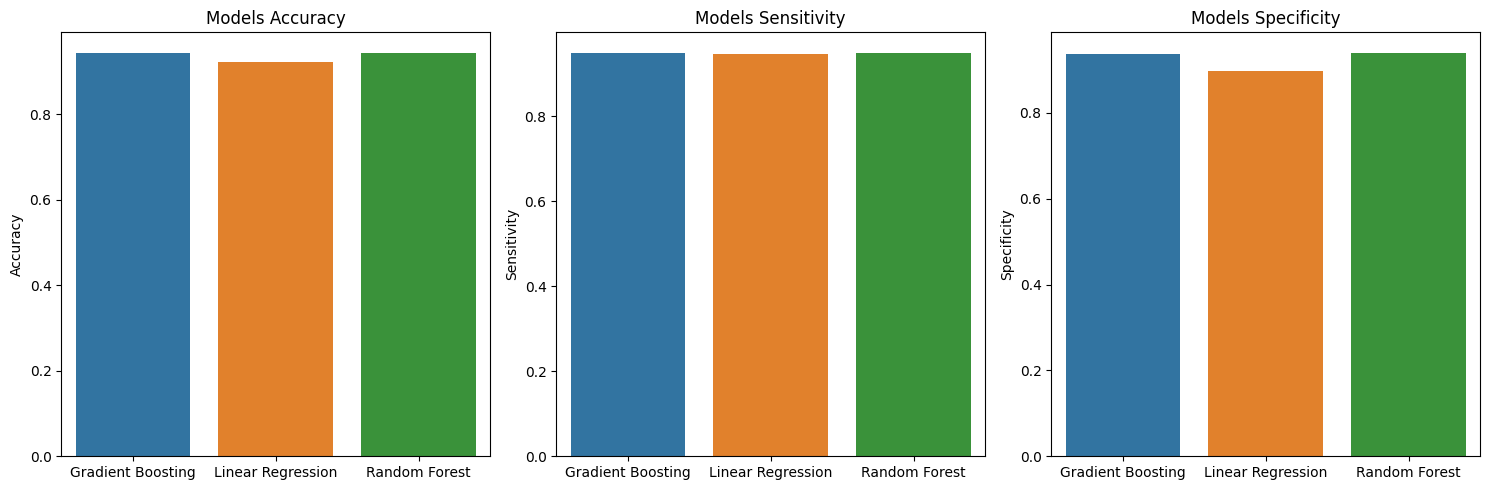

In [52]:
# create plot for performance evaluation
fig, axs = plt.subplots(1, 3, figsize=(15,5))

sns.barplot(x=perf_tbl.index, y='Accuracy', data=perf_tbl, ax=axs[0])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Models Accuracy')

sns.barplot(x=perf_tbl.index, y='Sensitivity', data=perf_tbl, ax=axs[1])
axs[1].set_ylabel('Sensitivity')
axs[1].set_title('Models Sensitivity')

sns.barplot(x=perf_tbl.index, y='Specificity', data=perf_tbl, ax=axs[2])
axs[2].set_ylabel('Specificity')
axs[2].set_title('Models Specificity')

plt.tight_layout()
plt.show()

**All three model's accuracy, sensitivity and specificity **

accuracy: a measure of how many predictions the model got correct. It's the ratio of correct predictions to total predictions.

sensitivity: a measure of the proportion of true positive predictions (i.e., the number of correct positive (TP) predictions) out of all the actual positive cases.

specificity: a measure of the proportion of true negative predictions (i.e., the number of correct negative predictions (FP) ) out of all the actual negative cases.

# Model summary

* The Gradient Boosting model has the highest accuracy, sensitivity, and specificity. It means that the model is able to correctly predict the price of most of the listings in the dataset and it doesn't have a high rate of false positives or false negatives.

* Linear Regression model has the lowest accuracy, sensitivity, and specificity among the three. It means that the model is not able to correctly predict the price of most of the listings in the dataset and it has a high rate of false positives or false negatives.

* In this case, Random Forest model might be the best option as it has the highest accuracy, sensitivity, specificity and lowest error rates and the highest R-squared value among the three models. However, this conclusion is based on the our features metric values.

# Recommendation

- As a property owner to focus on entire homes/apartments: Since the majority of listings are entire homes/apartments (5,225) and they have a higher average price ($ 180.78), focusing on this room type could maximize your revenue. Private rooms have a lower average price ($ 94.50) but still represent a significant portion of the market (927 listings). Shared rooms and hotel rooms have very few listings, and their average prices are lower ($ 61.00 and $0.00, respectively), so they may not be as lucrative.

- Target popular neighborhoods: The data shows that neighborhoods like Capitol Hill, Downtown, and Queen Anne have higher average prices and a significant number of listings. Focusing on these areas can help you attract more guests and potentially generate higher revenue.

- Offer desirable amenities: The top 10 most common amenities with higher average prices are Pool, Full kitchen, Dishwasher, Bathtub, TV, Washer, Backyard, Coffee maker, Gym, and Elevator. Offering these amenities can make your listing more appealing to potential guests and help you justify a higher price.
 
- Optimize property features: The feature importance list suggests that bedrooms, accommodates, minimum nights, beds, and longitude are the most important factors influencing price. To maximize your revenue, consider optimizing these features. For example, you could offer more bedrooms or beds, or adjust the minimum nights based on demand patterns.

- Use data-driven pricing: To set competitive prices, consider the average price by room type and neighborhood as a starting point. You can further refine your pricing strategy by taking into account factors such as seasonality, local events, and competitor pricing.

- Highlight unique selling points: If your property is located in a popular neighborhood or offers desirable amenities, be sure to highlight these features in your listing description and photos. This will help attract more guests and justify a higher price.